In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import matplotlib.pyplot as plt
import time
def elapsed(sec):
    if sec < 60:
        return "{:.2f}".format(sec) + " sec"
    elif sec < (60 * 60):
        return "{:.2f}".format(sec / 60) + " min"
    else:
        return "{:.2f}".format(sec / (60 * 60)) + " hr"
def showimg(img):
    plt.figure("Image")
    plt.imshow(img,cmap='gray')
    plt.axis('on')
    plt.title('image')
    plt.show()


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
HIDDEN_SIZE=512
INPUT_SIZE_IN=31
INPUT_SIZE_OUT=784
INPUT_NUMBER=512
NUM_LAYERS=2
TIMESTEPS=28

In [4]:
def LstmCell(HIDDEN_SIZE):
    # lstm_cell = rnn.BasicLSTMCell(HIDDEN_SIZE)
    lstm_cell = rnn.LSTMCell(HIDDEN_SIZE)
    return lstm_cell


def RNN(x, weights, biases, HIDDEN_SIZE, TIMESTEPS, NUM_LAYERS):
    x = tf.reshape(x, [-1, TIMESTEPS])
    x = tf.split(x, TIMESTEPS, 1)
    rnn_cell = rnn.MultiRNNCell([LstmCell(HIDDEN_SIZE) for _ in range(NUM_LAYERS)])
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


def RNN_onehot_in(x, weights, biases, HIDDEN_SIZE, INPUT_SIZE_IN, TIMESTEPS, NUM_LAYERS):
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, INPUT_SIZE_IN])
    x = tf.matmul(x, weights['in']) + biases['in']
    x = tf.split(x, TIMESTEPS, 0)
    rnn_cell = rnn.MultiRNNCell([LstmCell(HIDDEN_SIZE) for _ in range(NUM_LAYERS)])
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    y=tf.nn.sigmoid(tf.matmul(outputs[-1], weights['out']) + biases['out'])
    cache={'x':x,'outputs':outputs,'states':states}
    return y,cache

In [5]:
batch_xs, batch_ys = mnist.train.next_batch(INPUT_NUMBER)
inp=[]
tran=[]
ind=np.zeros(3)
for i in range(len(batch_xs)):
    t_=batch_xs[i].reshape(28,28)
    t_=t_.reshape(-1)
    tran.append(t_)
    z=ind
    z[0]=1
    z=np.tile(z,28).reshape(28,-1)
    inp_=np.append(batch_xs[i].reshape(28,28),z,axis=1)
    inp.append(inp_)
for i in range(len(batch_xs)):
    t_=batch_xs[i][::-1].reshape(28,28)
    t_=t_.reshape(-1)
    tran.append(t_)
    z=ind
    z[1]=1
    z=np.tile(z,28).reshape(28,-1)
    inp_=np.append(batch_xs[i].reshape(28,28),z,axis=1)
    inp.append(inp_)
for i in range(len(batch_xs)):
    im=batch_xs[i].reshape(28,28)
    im_=np.zeros((im.shape[1],im.shape[0]))
    for j in range(im.shape[0]):
        im_[:,-j]=im[j]
    t_=im_
    t_=t_.reshape(-1)
    tran.append(t_)
    z=ind
    z[2]=1
    z=np.tile(z,28).reshape(28,-1)
    inp_=np.append(batch_xs[i].reshape(28,28),z,axis=1)
    inp.append(inp_)
inp=np.array(inp).reshape(-1,28,31)
tran=np.array(tran).reshape(-1,784)
print(inp.shape)
print(tran.shape)

(1536, 28, 31)
(1536, 784)


In [6]:
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.001,global_step,2000, 0.98, staircase=True) 

In [7]:
x = tf.placeholder("float", [None, TIMESTEPS, INPUT_SIZE_IN])
labels=tf.placeholder(tf.float32, [None, 784])

weights = {
    'out': tf.Variable(tf.random_normal([HIDDEN_SIZE, INPUT_SIZE_OUT])),
    'in': tf.Variable(tf.random_normal([INPUT_SIZE_IN, HIDDEN_SIZE]))
}
biases = {
    'out': tf.Variable(tf.random_normal([INPUT_SIZE_OUT])),
    'in': tf.Variable(tf.random_normal([HIDDEN_SIZE]))
}

sess = tf.InteractiveSession()
y,cache = RNN_onehot_in(x, weights, biases, HIDDEN_SIZE, INPUT_SIZE_IN, TIMESTEPS, NUM_LAYERS)
loss=tf.losses.mean_squared_error(labels,y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss,global_step=global_step)
init = tf.global_variables_initializer()
sess.run(init)

In [8]:

cost=1
i=0
start_time=time.time()
while cost>0.0001:
    unuse,cost=sess.run([optimizer,loss],feed_dict={x:inp,labels:tran})
    if i % 1000==0:
        print(cost)
    if i==500:
        tpi=(time.time() - start_time)/500
        print('TPI:'+str(tpi)+'sec')
    i+=1
print('ITERATION:'+str(i))
print("Elapsed time: ", elapsed(time.time() - start_time))

0.37574354
TPI:0.4608935389518738sec
0.013269901


KeyboardInterrupt: 

In [ ]:
o=sess.run(cache,feed_dict={x:inp[5].reshape(1,28,-1)})
print(o['x'][0].shape)

In [ ]:
o=sess.run(y,feed_dict={x:inp[5].reshape(1,28,-1)})
showimg(o.reshape(28,28))

In [ ]:
img_index=77

In [ ]:
showimg(tran[77].reshape(28,28))

In [10]:
newimg,lb=mnist.train.next_batch(1)
newimg=batch_xs[9]
newimg=newimg.reshape(-1)

IMAGE_TRAINING_SET:


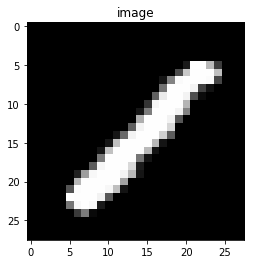

GROUND TRUTH1:


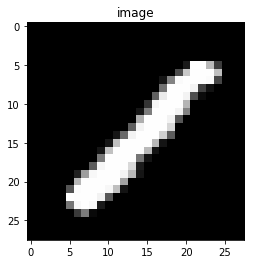

TRANS1:


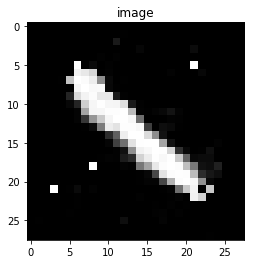

GROUND TRUTH2:


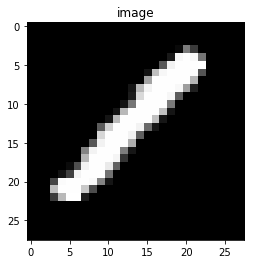

TRANS2:


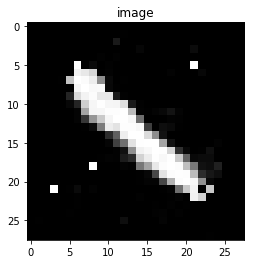

GROUND TRUTH3:


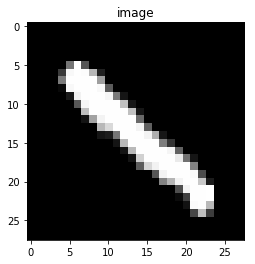

TRANS3:


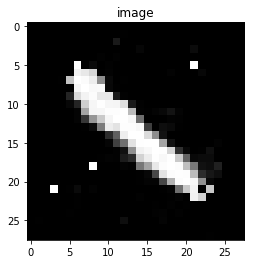

In [11]:
print('IMAGE_TRAINING_SET:')
showimg(newimg.reshape(28,28))
print('GROUND TRUTH1:')
showimg(newimg.reshape(28,28))
print('TRANS1:')
z=ind
z[0]=1
z=np.tile(z,28).reshape(28,-1)
inpt=np.append(newimg.reshape(28,28),z,axis=1)
inpt=inpt.reshape(1,28,-1)
oupt=sess.run(y,feed_dict={x:inpt})
showimg(oupt.reshape(28,28))
print('GROUND TRUTH2:')
newimg1=newimg[::-1].reshape(28,28)
newimg1=newimg1.reshape(-1)
showimg(newimg1.reshape(28,28))
print('TRANS2:')
z=ind
z[1]=1
z=np.tile(z,28).reshape(28,-1)
inpt=np.append(newimg.reshape(28,28),z,axis=1)
inpt=inpt.reshape(1,28,-1)
oupt=sess.run(y,feed_dict={x:inpt})
showimg(oupt.reshape(28,28))
print('GROUND TRUTH3:')
im=newimg.reshape(28,28)
im_=np.zeros((im.shape[1],im.shape[0]))
for i in range(im.shape[0]):
    im_[:,-i]=im[i]
showimg(im_)
print('TRANS3:')
z=ind
z[2]=1
z=np.tile(z,28).reshape(28,-1)
inpt=np.append(newimg.reshape(28,28),z,axis=1)
inpt=inpt.reshape(1,28,-1)
oupt=sess.run(y,feed_dict={x:inpt})
showimg(oupt.reshape(28,28))

In [ ]:
newimg,lb=mnist.test.next_batch(1)
newimg=newimg.reshape(-1)

In [ ]:

ind=np.zeros(3)
print('IMAGE_TEST_SET:')
showimg(newimg.reshape(28,28))
print('GROUND TRUTH1:')
showimg(newimg.reshape(28,28))
print('TRANS1:')
z=ind
z[0]=1
z=np.tile(z,28).reshape(28,-1)
inpt=np.append(newimg.reshape(28,28),z,axis=1)
inpt=inpt.reshape(1,28,-1)
oupt=sess.run(y,feed_dict={x:inpt})
showimg(oupt.reshape(28,28))
print('GROUND TRUTH2:')
newimg1=newimg[::-1].reshape(28,28)
newimg1=newimg1.reshape(-1)
showimg(newimg1.reshape(28,28))
print('TRANS2:')
z=ind
z[1]=1
z=np.tile(z,28).reshape(28,-1)
inpt=np.append(newimg.reshape(28,28),z,axis=1)
inpt=inpt.reshape(1,28,-1)
oupt=sess.run(y,feed_dict={x:inpt})
showimg(oupt.reshape(28,28))
print('GROUND TRUTH3:')
im=newimg.reshape(28,28)
im_=np.zeros((im.shape[1],im.shape[0]))
for i in range(im.shape[0]):
    im_[:,-i]=im[i]
showimg(im_)
print('TRANS3:')
z=ind
z[2]=1
z=np.tile(z,28).reshape(28,-1)
inpt=np.append(newimg.reshape(28,28),z,axis=1)
inpt=inpt.reshape(1,28,-1)
oupt=sess.run(y,feed_dict={x:inpt})
showimg(oupt.reshape(28,28))


In [ ]:
ind=np.zeros(3)
ind[0]=1

In [ ]:
print(np.tile(ind,3))
ind=np.tile(ind,3)


In [ ]:
ind=ind.reshape(3,3)

In [ ]:
ind

In [ ]:
ind.repeat(3).shape